In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

In [3]:
# Load JSON data from file
with open("/content/drive/MyDrive/SmartFactory/Dataset/processed_sensor_data.json", 'r') as f:
    data = json.load(f)

In [4]:
# Convert list of dicts to DataFrame
df = pd.DataFrame(data)

In [5]:
df.head()

,timestamp,machine_id,temperature,vibration,rpm,pressure,humidity,voltage,failure,year,...,voltage_lag_1,voltage_lag_2,temperature_roc,vibration_roc,rpm_roc,pressure_roc,humidity_roc,voltage_roc,temperature_cummax,vibration_cummax
0,2015-05-26T20:55:13.644,B-MY9,71.47,0.94,2694,7.50,65.72,215.55,0,2015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71.47,0.94
1,2015-05-27T20:15:37.644,N-PR7,64.60,2.44,3054,6.96,44.25,226.71,0,2015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.60,2.44
2,2015-05-28T07:53:40.644,Y-09D,76.14,1.93,2952,6.41,51.60,243.14,0,2015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,76.14,1.93
3,2015-05-29T09:45:29.644,X-PYA,73.72,1.87,2607,7.13,59.94,229.21,0,2015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73.72,1.87
4,2015-05-30T06:22:48.644,G-2H4,77.37,0.57,3063,4.08,47.57,221.11,0,2015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77.37,0.57


In [6]:
# Feature & target selection
target = "failure"
non_features = ["timestamp", "machine_id", target]
X = df.drop(columns=non_features)
y = df[target]

In [7]:

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, stratify=y, random_state=42)

In [8]:
# Define pipelines for Logistic Regression and Random Forest with imputation
lr_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('classifier', LogisticRegression(max_iter=1000))
])

rf_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

In [9]:
# Train models
lr_pipeline.fit(X_train, y_train)
rf_pipeline.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('imputer', SimpleImputer()),
                ('classifier', RandomForestClassifier(random_state=42))])

In [10]:
# Evaluation function
def evaluate_model(name, pipeline, X_test, y_test):
    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]

    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} – Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc_score(y_test, y_proba):.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.title(f"{name} – ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid()
    plt.show()

              precision    recall  f1-score   support

           0       0.92      0.98      0.95       901
           1       0.59      0.23      0.33        99

    accuracy                           0.91      1000
   macro avg       0.76      0.61      0.64      1000
weighted avg       0.89      0.91      0.89      1000



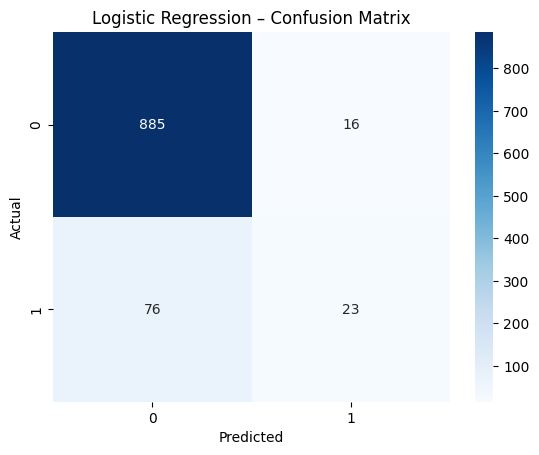

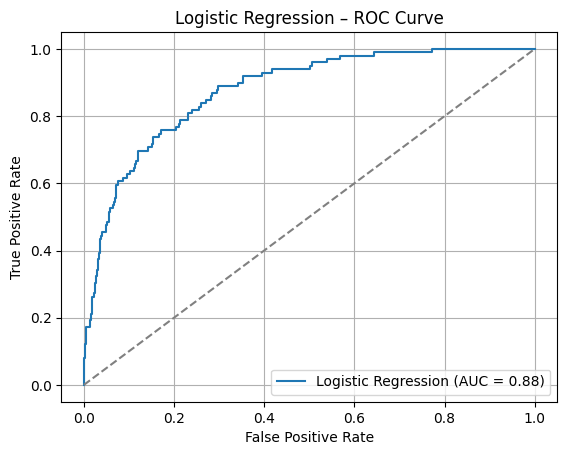

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       901
           1       1.00      0.78      0.88        99

    accuracy                           0.98      1000
   macro avg       0.99      0.89      0.93      1000
weighted avg       0.98      0.98      0.98      1000



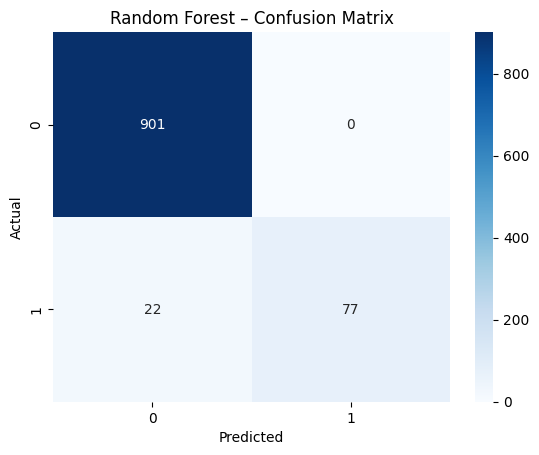

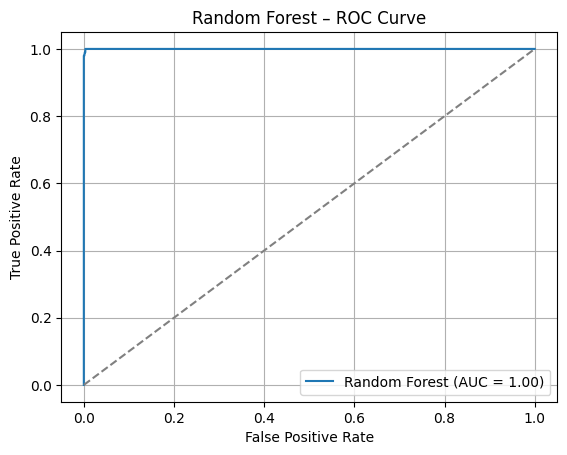

In [11]:
# Evaluate both models
evaluate_model("Logistic Regression", lr_pipeline, X_test, y_test)
evaluate_model("Random Forest", rf_pipeline, X_test, y_test)

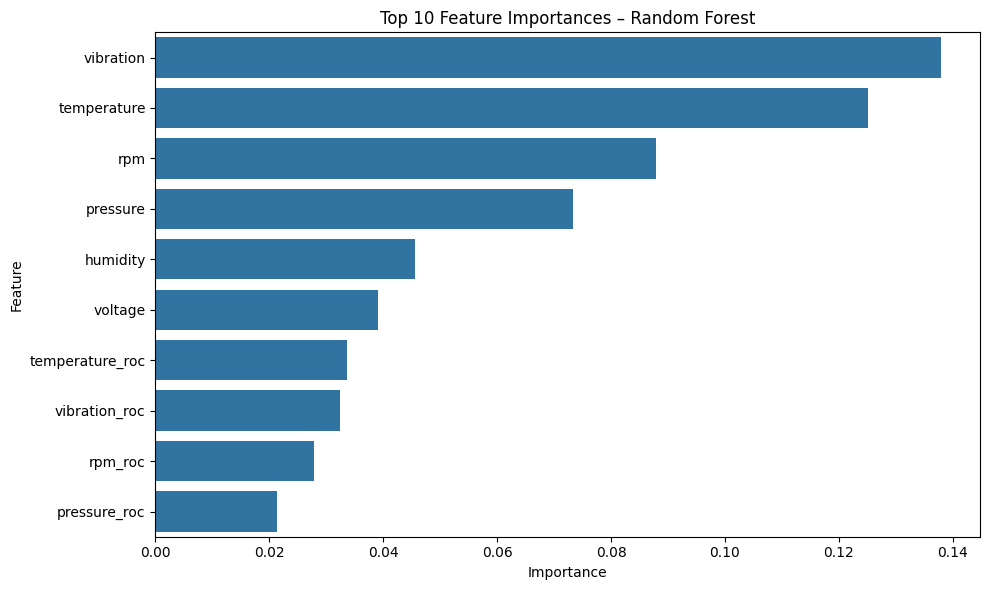

In [12]:
# Feature importance (only for Random Forest)
# Extract feature importances after imputing training data
imputer = SimpleImputer(strategy='mean')
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
rf = rf_pipeline.named_steps['classifier']

importances = rf.feature_importances_
features = X_train_imputed.columns
importance_df = pd.DataFrame({
    "Feature": features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=importance_df.head(10))
plt.title("Top 10 Feature Importances – Random Forest")
plt.tight_layout()
plt.show()

In [13]:
# Save pipelines and test data

joblib.dump(lr_pipeline, "/content/drive/MyDrive/SmartFactory/Models/logistic_regression_week3.pkl")
joblib.dump(rf_pipeline, "/content/drive/MyDrive/SmartFactory/Models/random_forest_week3.pkl")

X_test.to_json("/content/drive/MyDrive/SmartFactory/Results/Week3/X_test_week3.json", orient="records", lines=True)
pd.DataFrame({"true": y_test}).to_json("/content/drive/MyDrive/SmartFactory/Results/Week3/Y_test_week3.json", orient="records", lines=True)